In [1]:
from time import time
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile, ClassicalRegister
from qiskit.quantum_info import partial_trace, Statevector, DensityMatrix, Operator
from qiskit.visualization import plot_histogram

from utilities import startup, bit_str_list, run_cal, check_provider
from graphstate import GraphState, calc_teleported_negativities, calc_n_mean, plot_cxerr_corr, plot_teleported_negativities_multi, plot_teleported_negativities_multi_gap
from free_entanglebase import Free_EntangleBase

provider = startup()

Account enabled
Provider: ibm-q-melbourne


In [2]:
check_provider()

ibmq_qasm_simulator has 2 queud and simulated qubits
ibmq_montreal has 183 queud and 27 qubits
ibmq_toronto has 3320 queud and 27 qubits
ibmq_kolkata has 1694 queud and 27 qubits
ibmq_mumbai has 86 queud and 27 qubits
ibmq_lima has 97 queud and 5 qubits
ibmq_belem has 46 queud and 5 qubits
ibmq_quito has 53 queud and 5 qubits
ibmq_guadalupe has 237 queud and 16 qubits
simulator_statevector has 2 queud and simulated qubits
simulator_mps has 2 queud and simulated qubits
simulator_extended_stabilizer has 2 queud and simulated qubits
simulator_stabilizer has 2 queud and simulated qubits
ibmq_jakarta has 236 queud and 7 qubits
ibmq_manila has 65 queud and 5 qubits
ibm_hanoi has 534 queud and 27 qubits
ibm_lagos has 126 queud and 7 qubits
ibm_nairobi has 117 queud and 7 qubits
ibm_cairo has 380 queud and 27 qubits
ibm_auckland has 871 queud and 27 qubits
ibm_perth has 247 queud and 7 qubits
ibm_washington has 582 queud and 127 qubits
ibm_oslo has 59 queud and 7 qubits
ibm_geneva has 744 queu

In [2]:
import networkx as nx

def get_negativity_info(n_list, nmit_list):
    
    n_mean_dict, _ = calc_n_mean(n_list)
    n_mean = np.mean(list(n_mean_dict.values()))
    std = np.std(list(n_mean_dict.values()))

    nmit_mean_dict, _ = calc_n_mean(nmit_list)
    nmit_mean = np.mean(list(nmit_mean_dict.values()))
    std_mit = np.std(list(nmit_mean_dict.values()))
    
    n5 = get_largest_connected(n_mean_dict, threshold=0.025)
    n50 = get_largest_connected(n_mean_dict, threshold=0.25)
    n75 = get_largest_connected(n_mean_dict, threshold=0.75*0.5)
    n90 = get_largest_connected(n_mean_dict, threshold=0.9*0.5)
    
    nmit5 = get_largest_connected(nmit_mean_dict, threshold=0.025)
    nmit50 = get_largest_connected(nmit_mean_dict, threshold=0.25)
    nmit75 = get_largest_connected(nmit_mean_dict, threshold=0.75*0.5)
    nmit90 = get_largest_connected(nmit_mean_dict, threshold=0.9*0.5)
    
    info_dict = {'Mean negativity': n_mean,
                 'std': std,
                'Mean negativity (mit)': nmit_mean,
                 'std (mit)': std_mit,
                'Connected N>5%': len(n5),
                'Connected N>50%': len(n50),
                'Connected N>75%': len(n75),
                'Connected N>90%': len(n90),
                'Connected N>5% (mit)': len(nmit5),
                'Connected N>50% (mit)': len(nmit50),
                'Connected N>75% (mit)': len(nmit75),
                'Connected N>90% (mit)': len(nmit90)}

    return info_dict

def get_largest_connected(n_dict, threshold=0.25):
    
    edges = filter_edges(n_dict, threshold)
    G = nx.Graph()
    G.add_edges_from(edges)
    try:
        largest = max(nx.connected_components(G), key=len)
    except:
        largest = {}
    
    return largest
    
def filter_edges(n_dict, threshold=0.25/2):
    return [key for key, value in n_dict.items() if value >= threshold]

In [3]:
# Post-processing
backend = provider.get_backend('ibm_oslo')
test = GraphState(backend)
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.gen_teleported_qst_circuits()
#test.teleported_BellState_circuits_qst[1][(0,2)]['ZZ'].draw()
job1 = test.run_teleported_qst_circuits(reps=1, shots=8192, qrem=True, sim=None)
job2 = test.run_teleported_qst_circuits(reps=1, shots=8192, qrem=True, sim=None)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())
#print(jobs.result().get_counts('2-(0, 5)-ZZ-0'))
#qst_counts, qst_pvecs = test.teleported_counts_from_result(jobs.result(), post_processing = True)
#qst_counts_mit, qst_pvecs_mit = test.apply_qrem_teleported_counts(qst_counts, qst_pvecs)
#pvecs_binned = test.bin_teleported_pvecs(qst_counts_mit, qst_pvecs_mit)
#pvecs_binned = test.bin_teleported_pvecs_from_dynamic_circuits(qst_counts_mit, qst_pvecs_mit)
#print(qst_counts[0][2][(0,5)]['ZZ']) #0th rep, gap = 2, pair = (0,5), basis = ZZ
#print(qst_pvecs[0][2][(0,5)]['ZZ'])
#print(qst_counts_mit[0][2][(0,5)]['ZZ'])
#print(qst_pvecs_mit[0][2][(0,5)]['ZZ'])
#print(pvecs_binned[0][2][(0,5)]['ZZ'])

Device: ibm_oslo (7 qubits)
Job 1 ID: 6402d7b5dfd0c1a3c40c22e4
Job 2 ID: 6402d7bca8f65f7ff7f0018f


In [2]:
time0 = time()
backend = provider.get_backend('ibm_oslo')

job1 = backend.retrieve_job('63f2dbf26fb5c02160d81dee')
job2 = backend.retrieve_job('63f2dbfa6fb5c09be8d81def')

#print(result[0])
#print(result.get_counts('1-(0, 2)-ZZ-0'))
qubits_to_connect = list(range(len(backend.properties().qubits)))
graphstate = GraphState(backend, qubits_to_connect = qubits_to_connect)
rho_dict1 = graphstate.recon_teleported_density_mats(job1.result(), post_processing = True, apply_mit=False)
rho_dict_mit1 = graphstate.recon_teleported_density_mats(job1.result(), post_processing = True, apply_mit=True)

rho_dict2 = graphstate.recon_teleported_density_mats(job2.result(), post_processing = True, apply_mit=False)
rho_dict_mit2 = graphstate.recon_teleported_density_mats(job2.result(), post_processing = True, apply_mit=True)

time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 30.07 s


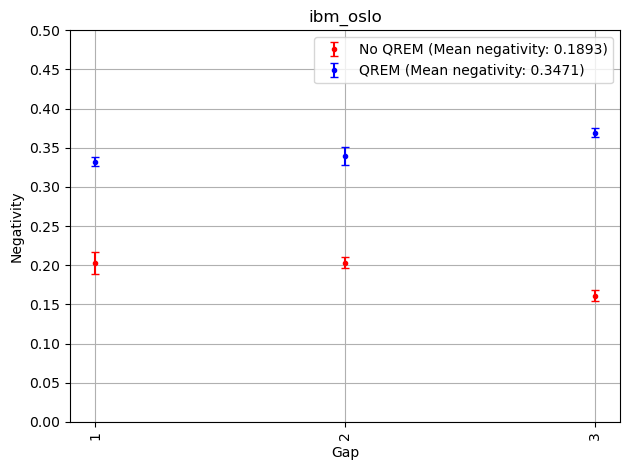

In [3]:
n_list1 = calc_teleported_negativities(rho_dict1, post_processing = True, mode='all')
nmit_list1 = calc_teleported_negativities(rho_dict_mit1, post_processing = True, mode='all')
n_list2 = calc_teleported_negativities(rho_dict2,  post_processing = True, mode='all')
nmit_list2 = calc_teleported_negativities(rho_dict_mit2,  post_processing = True, mode='all')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_teleported_negativities_multi_gap(backend, n_list, nmit_list, bellstate = 'BS_1')
fig.tight_layout()

#Note dynamic circuit give same data structure as if mode is 'mean' or 'max' or 'min' i.e. gap-pair-negativity structure
#n_list1 = calc_teleported_negativities(rho_dict1, post_processing = False, mode='all')
#nmit_list1 = calc_teleported_negativities(rho_dict_mit1, post_processing = False, mode='all')
#n_list2 = calc_teleported_negativities(rho_dict2,  post_processing = False, mode='all')
#nmit_list2 = calc_teleported_negativities(rho_dict_mit2,  post_processing = False, mode='all')
#n_list = n_list1 + n_list2
#nmit_list = nmit_list1 + nmit_list2

#fig = plot_teleported_negativities_multi(backend, n_list, nmit_list)
#fig.tight_layout()


In [1]:
# Dynamic Circuits
from time import time
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile, ClassicalRegister
#from qiskit.providers.ibmq.managed import ManagedResults, ManagedJobSet, IBMQJobManager
from qiskit.quantum_info import partial_trace, Statevector, DensityMatrix, Operator
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider

#from utilities import startup, bit_str_list, run_cal, check_provider
from graphstate import GraphState, calc_teleported_negativities, calc_n_mean, plot_cxerr_corr, plot_teleported_negativities_multi, plot_teleported_negativities_multi_gap
from entanglebase import EntangleBase

hub = "ibm-q-melbourne"
group = "unimelb"
project = "hub"

#hub = "ibm-q"
#group = "open"
#project = "main"

backend_name = 'ibm_perth'
hgp = f"{hub}/{group}/{project}"

provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)

In [2]:
len(backend.properties().qubits)
print(backend.name)

ibm_perth


270
1-(0, 2)-XX-0


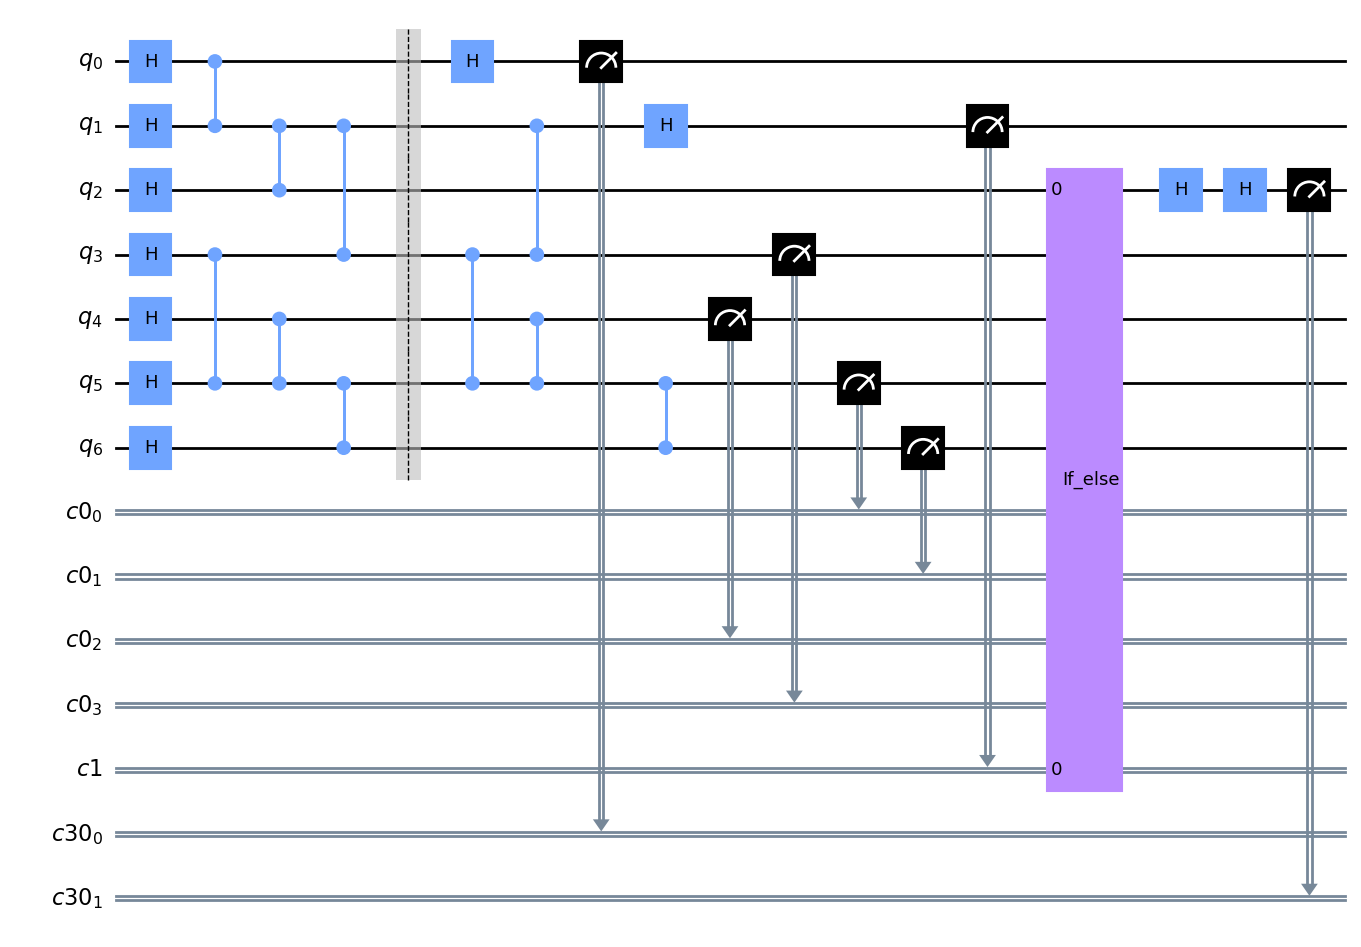

In [2]:
#testing block
graphstate = GraphState(backend)
graphstate.gen_teleportation_basis()
graphstate.gen_teleported_BellState_circuit(post_processing = False)
graphstate.gen_teleported_qst_circuits()
#circuits = graphstate.teleported_BellState_circuits_qst[1]
#circuit2 = graphstate.teleported_BellState_circuits_qst[1][(0,2)]['XX']
circ_list = []
for pairs_dict in graphstate.teleported_BellState_circuits_qst.values():
    for basis_dict in pairs_dict.values():
        for circuit in basis_dict.values():
            circ_list.append(circuit)

circ_list_multi = []
for i in range(2):
    for circ in circ_list:
        name_ext = circ.name + f'-{i}'
        circ_list_multi.append(circ.copy(name_ext))

circ_list = circ_list_multi
#circ_list = graphstate.gen_qrem_circuits()
print(len(circ_list))
#print(provider.backends())
#for circ in circ_list:
#    print(circ.name)

#job_manager = IBMQJobManager()
#job_set = job_manager.run(circ_list, backend=backend, dynamic = True)
#results = ManagedResults(job_set, 'ibm_perth', False)
#combined_result = results.combine_results()

circ_transpiled = transpile(circ_list, backend = graphstate.backend)
print(circ_list[0].name)
circ_list[0].draw('mpl')
#print(circ_transpiled)
#job = graphstate.backend.run(circ_transpiled, shots = 4096, dynamic = True)
#print(job.job_id())
#job = graphstate.run_teleported_qst_circuits(reps=1, shots=4096, qrem=False, sim=None)

In [6]:
#job submission block (split job into pair-basis to prevent memory overflow)
import csv

jobs_id = []
jobs_id.append(['jobs','jobs_id'])

graphstate = GraphState(backend)
graphstate.gen_teleportation_basis()
graphstate.gen_teleported_BellState_circuit(post_processing = False)
graphstate.gen_teleported_qst_circuits()

circuits = {gap: {pair: [circuit for circuit in basis_dict.values()] 
                   for pair, basis_dict in pairs_dict.items()} 
             for gap, pairs_dict in graphstate.teleported_BellState_circuits_qst.items()}

for i in range(4):
    for gap, pairs_dict in circuits.items():
        for pair, circ_list in pairs_dict.items():
            new_circ_list = []
            for circ in circ_list:
                name_ext = circ.name + f'-{i}'
                circ.name = name_ext
                new_circ_list.append(circ)
            circ_transpiled = transpile(new_circ_list, backend = graphstate.backend)
            job = graphstate.backend.run(circ_transpiled, shots = 4096, dynamic = True)
            jobs_id.append([f'{i}-{gap}-{pair}', job.job_id()])

fp = open('Dynamic circuits for teleportation of BellState-manila-rep4','w')
writer = csv.writer(fp, delimiter='|')
writer.writerows(jobs_id)
fp.close()

In [5]:
#job submission block (split job into pair-basis to prevent memory overflow)
import csv

jobs_id = []
jobs_id.append(['job','jobs_id'])

graphstate = GraphState(backend)
graphstate.gen_teleportation_basis()
graphstate.gen_teleported_BellState_circuit(post_processing = False)
graphstate.gen_teleported_qst_circuits()

qrem_circ_list = graphstate.gen_qrem_circuits()
#qrem_circ_list[1].draw()
qrem_cric_transpiled = transpile(qrem_circ_list, backend = graphstate.backend)
job = graphstate.backend.run(qrem_cric_transpiled, shots = 4096)

jobs_id.append(['qrem', job.job_id()])
fp = open('qrem for teleportation of BellState-perth','w')
writer = csv.writer(fp, delimiter='|')
writer.writerows(jobs_id)
fp.close()

In [2]:
import csv
jobs_id = {}

fp = open('Dynamic circuits for teleportation of BellState-perth-rep1','r')
#fp = open('qrem for teleportation of BellState-perth','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        print(row)
        jobs_id[row[0]] = row[1]
    line_count += 1
fp.close()
print(jobs_id)

['0-1-(0, 2)', 'cfu4irdu7afut8fk87f0']
['1-1-(0, 3)', 'cfumikutm3omfc73rbeg']
['0-1-(1, 5)', 'cfu4isbmcdu7bt2githg']
['0-1-(2, 3)', 'cfu4isjmcdu7bt2gito0']
['0-1-(3, 4)', 'cfu4it3mcdu7bt2giu4g']
['0-1-(3, 6)', 'cfu4itopvdjh4faan2rg']
['0-1-(4, 6)', 'cfu4iubmcdu7bt2giuqg']
['0-2-(0, 5)', 'cfu4iulu7afut8fk899g']
['0-2-(1, 4)', 'cfu4iv3mcdu7bt2givfg']
['0-2-(1, 6)', 'cfu4ivdu7afut8fk89fg']
['0-2-(2, 5)', 'cfu4ivlu7afut8fk89kg']
['0-3-(0, 4)', 'cfu4j0dhebj7smmtu9jg']
['0-3-(0, 6)', 'cfu4j2du7afut8fk8at0']
['0-3-(2, 4)', 'cfu4j2gpvdjh4faan5b0']
['0-3-(2, 6)', 'cfu4j33mcdu7bt2gj250']
{'0-1-(0, 2)': 'cfu4irdu7afut8fk87f0', '1-1-(0, 3)': 'cfumikutm3omfc73rbeg', '0-1-(1, 5)': 'cfu4isbmcdu7bt2githg', '0-1-(2, 3)': 'cfu4isjmcdu7bt2gito0', '0-1-(3, 4)': 'cfu4it3mcdu7bt2giu4g', '0-1-(3, 6)': 'cfu4itopvdjh4faan2rg', '0-1-(4, 6)': 'cfu4iubmcdu7bt2giuqg', '0-2-(0, 5)': 'cfu4iulu7afut8fk899g', '0-2-(1, 4)': 'cfu4iv3mcdu7bt2givfg', '0-2-(1, 6)': 'cfu4ivdu7afut8fk89fg', '0-2-(2, 5)': 'cfu4ivlu7afut8fk89k

In [3]:
import csv
qrem_id = {}

fp = open('qrem for teleportation of BellState-perth','r')
#fp = open('qrem for teleportation of BellState-perth','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        print(row)
        qrem_id[row[0]] = row[1]
    line_count += 1
fp.close()
print(qrem_id)

['qrem', 'cg3un5364fmol8b1si4g']
{'qrem': 'cg3un5364fmol8b1si4g'}


In [3]:
# Dynamic Circuits
#backend = provider.get_backend('ibm_oslo')
graphstate = GraphState(backend)
graphstate.gen_teleportation_basis()
graphstate.gen_teleported_BellState_circuit(post_processing = False)
graphstate.gen_teleported_qst_circuits()
graphstate.teleported_BellState_circuits_qst[1][(0,2)]['ZZ'].draw('mpl')

job1 = graphstate.run_teleported_qst_circuits(reps=2, shots=8192, qrem=False, sim=None)
#job2 = graphstate.run_teleported_qst_circuits(reps=2, shots=8192, qrem=False, sim=None)

#print("Device:", backend_name, f'({len(backend.properties().qubits)} qubits)')
#print("Job 1 ID:", job1.job_id())
#print("Job 2 ID:", job2.job_id())

IBMQBackendValueError: 'The IBMQ provider is being deprecated and does not support dynamic circuits. Please use the qiskit-ibm-provider instead. See the documentation for more information on usage - https://qiskit.org/documentation/partners/qiskit_ibm_provider/. '

In [4]:
time0 = time()
#backend_service = IBMBackendService(provider, hgp = hgp)
#job = backendservice.retrieve_job('cfu4j33mcdu7bt2gj250')
#job = provider.backend.retrieve_job('cfumikutm3omfc73rbeg')
#print(job.result().results[8].name)
#print(job.result().get_counts('1-(0, 3)-XY-1'))
#job2 = backend.retrieve_job('cfqpgjjlcn34i20evmrg')

graphstate = GraphState(backend)
rho_dict_list = graphstate.recon_teleported_density_mats_from_multi(jobs_id, qrem_id, apply_mit = False)
rho_dict_list_mit = graphstate.recon_teleported_density_mats_from_multi(jobs_id, qrem_id, apply_mit = True)
print(rho_dict_list[0])
print(rho_dict_list_mit[0])
#rho_dict1 = graphstate.recon_teleported_density_mats_from_multi(jobs_id)

time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

{1: {(0, 2): array([[ 0.24222819+4.82930033e-19j,  0.15889486+6.10351563e-04j,
         0.10465495+6.66097005e-02j, -0.02441406+3.68652344e-02j],
       [ 0.15889486-6.10351563e-04j,  0.27372233+4.41940583e-18j,
         0.09521484+5.46875000e-02j, -0.03670247+4.56136068e-02j],
       [ 0.10465495-6.66097005e-02j,  0.09521484-5.46875000e-02j,
         0.29048665+2.33126558e-18j, -0.09574382+4.96826172e-02j],
       [-0.02441406-3.68652344e-02j, -0.03670247-4.56136068e-02j,
        -0.09574382-4.96826172e-02j,  0.19356283+5.34314376e-18j]]), (0, 3): array([[ 0.24157715+5.98392629e-18j,  0.16499837+4.06901042e-05j,
         0.17525228+6.77897135e-02j, -0.10021973+1.23291016e-02j],
       [ 0.16499837-4.06901042e-05j,  0.27469889+9.04072099e-18j,
         0.15563965+9.63134766e-02j, -0.11796061+5.99772135e-02j],
       [ 0.17525228-6.77897135e-02j,  0.15563965-9.63134766e-02j,
         0.28633626+6.04012655e-18j, -0.1130778 +8.69547526e-02j],
       [-0.10021973-1.23291016e-02j, -0.117960

In [10]:
def calc_teleported_n_mean(n_list):
    '''Calculate mean negativity dict '''
    reps = len(n_list)
    pairs_number = {gap: len(pairs_dict) for gap, pairs_dict in n_list[0].items()}
    #n_dict = {gap: {pair: [n_list[i][gap][pair]['BS_1'] for i in range(reps)] 
    #                for pair in pairs_dict.keys()} 
    #          for gap, pairs_dict in n_list[0].items()}
    
    n_dict = {gap: [n_list[i][gap][pair] for pair in pairs_dict.keys() for i in range(reps)] 
              for gap, pairs_dict in n_list[0].items()}
    
    n_mean = {gap: np.mean(negativities)
              for gap, negativities in n_dict.items()}
    
    n_std_err = {gap: np.std(negativities)/np.sqrt(reps*pairs_number[gap])  
              for gap, negativities in n_dict.items()}

    return n_mean, n_std_err

def plot_teleported_negativities_dynamic(n_list, backend, nmit_list=None, figsize=(6.4, 4.8)):
    """
    Plot average negativity across multiple experiments with error bars as std

    """

    # Figure
    fig, ax = plt.subplots(figsize=figsize)

    # Extract the mean negativity and its standard deviation
    gaps = []
    for gap, pairs_dict in n_list[0].items():
            gaps.append(f'{gap}')

    n_mean, n_std = calc_teleported_n_mean(n_list)
    
    n_mean_list = []
    n_std_list = []
    for gap, mean in n_mean.items():
        n_mean_list.append(mean)
            
    for gap, std in n_std.items():
        n_std_list.append(std)
        
    # Convert into array for plotting
    X = np.array(gaps)
    Y0 = np.array(n_mean_list)
    Y0err = np.array(n_std_list)
    print(X)
    print(Y0)
    print(Y0err)
    
    try:
        nmit_mean, nmit_std = calc_teleported_n_mean(nmit_list)
        n_mit_mean_list = []
        n_mit_std_list = []
        for gap, mean in nmit_mean.items():
            n_mit_mean_list.append(mean)
            
        for gap, std in nmit_std.items():
            n_mit_std_list.append(std)

        Y1 = np.array(n_mit_mean_list)
        Y1err = np.array(n_mit_std_list)
        # Order in increasing minimum negativity (QREM)
        #Y1min = Y1 - Y1err
        #idx = Y1min.argsort()#find the indicies that sort Y1min from smallest to largest
        #Y1 = Y1[idx]#then put all negativities in such order (indicies)
        #Y1err = Y1err[idx]
    except:
        # Order in increasing minimum negativity (No QREM)
        Y0min = Y0 - Y0err
        idx = Y0min.argsort()

    
    # Plot
    ax.errorbar(X, Y0, yerr=Y0err, capsize=3, fmt='.', c='r', label=f'No QREM (Mean negativity: {np.mean(Y0):.4f})')
    
    try:
        ax.errorbar(X, Y1, yerr=Y1err, capsize=3, fmt='.', c='b', 
                    label=f'QREM (Mean negativity: {np.mean(Y1):.4f})')
    except:
        pass
    
    # Fig params
    ax.set_yticks(np.arange(0, 0.55, 0.05))
    ax.tick_params(axis='x', labelrotation=90)
    ax.grid()
    ax.legend()

    ax.set_xlabel("Qubit Pairs")
    ax.set_ylabel("Negativity")
    #ax.set_title(f"Native-graph state negativities ({backend.name()})")
    ax.set_title(backend.name)

    return fig

['1' '2' '3']
[0.13979574 0.07736401 0.06785534]
[0.03999385 0.06500993 0.01764468]


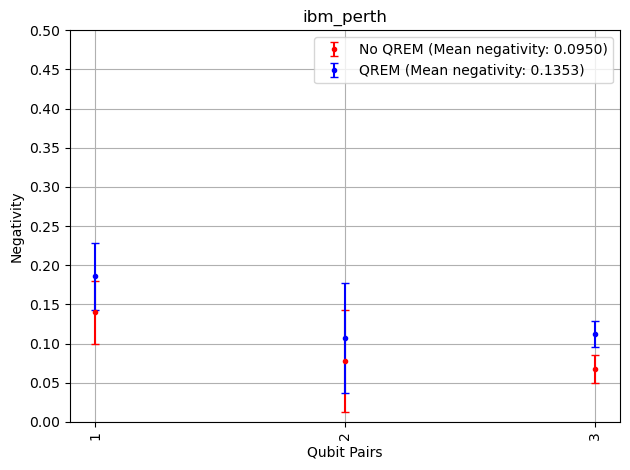

In [12]:
#Note dynamic circuit give same data structure as if mode is 'mean' or 'max' or 'min' i.e. gap-pair-negativity structure
#therefore plot_teleported_negativities_multi is enough as it calls calc_teleported_n_mean (not gap)
n_list = calc_teleported_negativities(rho_dict_list, post_processing = False, mode='mean')
n_list_mit = calc_teleported_negativities(rho_dict_list_mit, post_processing = False, mode='mean')
#print(n_list)
#mean_negativities = {i+1: 0 for i in range(3)}
#for i in range(graphstate.reps):
#    for gap, pairs_dict in n_list[i].items():
#        mean = 0
#        for n in pairs_dict.values():
#            mean += n
#        mean /= len(pairs_dict)
#        mean_negativities[gap] = mean
#print(mean_negativities)
#n_mean, n_std_err = calc_teleported_n_mean(n_list)
#print(n_mean)
fig = plot_teleported_negativities_dynamic(n_list=n_list , backend = backend, nmit_list = n_list_mit)
fig.tight_layout()

In [3]:
int('1')

1